In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'release'))

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE

## Past models of myosin dynamics

Increasing sparsity:

    D_t m_ij  = 1.431 m_ij Tr(E_passive)
    D_t m_ij = 0.305 * Tr(m) * m_ij - 0.160 * {m, E}
    D_t m_ij  = 0.007 Static_DV Tr(m_ij) + 1.368 m_ij Tr(E_passive) + 0.188 m_ij Tr(m_ij)
    D_t m_ij  = 0.024 Static_DV Tr(m_ij) + -0.023 m_ij + 1.335 m_ij Tr(E_passive) + 0.152 m_ij Tr(m_ij)
    D_t m_ij  = 0.095 Static_DV Tr(m_ij) + -0.001 m_ij + 1.402 m_ij Tr(E_passive) + 0.220 m_ij Tr(m_ij) + 0.008 {m_ij, E_passive} + -0.054 {m_ij, Static_DV}
    D_t m_ij  = -0.001 E_passive + 0.034 E_passive Tr(m_ij) + 0.122 Static_DV Tr(m_ij) + 0.030 m_ij + 1.357 m_ij Tr(E_passive) + -0.075 m_ij Tr(m_ij) + 0.332 m_ij m_ij + -0.021 {m_ij, E_passive} + -0.083 {m_ij, Static_DV}

Without a dorsal source:

    D_t m_ij  = -0.010 m_ij + 1.351 m_ij Tr(E_passive) + 0.012 Static_DV Tr(m_ij) + 0.221 m_ij Tr(m_ij)

With a dorsal source:

    D_t m_ij  = -0.016 m_ij + 1.319 m_ij Tr(E_passive) + 0.022 Static_DV Tr(m_ij) + 0.129 m_ij Tr(m_ij) + 0.026 Dorsal_Source m_ij + -0.290 Dorsal_Source m_ij Tr(E_passive) + -0.003 Dorsal_Source Static_DV + 0.007 Dorsal_Source m_ij Tr(m_ij)        

Closed loop PINN version 03232023:

    D_t m = -(0.514 - 0.549 s) m + (1.34 - 1 s){m, E_p} + (1.74 - 1.77 s) Tr(m) Gamma^{DV} + (1.66 - 1.68 s) Tr(m) m

Closed loop PINN version 03282023:

    D_t m = -(0.644 - 1.09 s) m + (1.02 - 1.2 s){m, E_p} + (0.891 - 1.47 s) Tr(m) Gamma^{DV} + (0.866 - 1.43 s) Tr(m) m

With ensemble-averaged cadherin:

    D_t m_ij  = 0.051 Static_DV Tr(m_ij) + -0.037 c Static_DV Tr(m_ij) + 0.077 c m_ij + -0.216 c m_ij Tr(E_full) + 1.003 c m_ij Tr(E_passive) + -0.528 c m_ij Tr(m_ij) + -0.085 m_ij + 1.465 m_ij Tr(E_full) + -1.814 m_ij Tr(E_passive) + 0.717 m_ij Tr(m_ij)
    
Retrained on the restricted dataset to fix coefficients

    D_t m_ij  = 0.047 Static_DV Tr(m_ij) + -0.034 c Static_DV Tr(m_ij) + 0.061 c m_ij + 0.310 c m_ij Tr(E_full) + -0.393 c m_ij Tr(m_ij) + -0.066 m_ij + 0.489 m_ij Tr(E_full) + 0.564 m_ij Tr(m_ij)

## Fly closed loop

{'num_latent': 64, 'hidden_size': 128, 'lstm_layers': 2, 'beta': 0.0001, 'lr': 0.0001, 'epochs': 500, 'mode': 'embryo', 'in_channels': 4, 'input': ['sqh'], 'stage_dims': [[32, 32], [64, 64], [128, 128], [256, 256, 64]], 'out_channels': 2, 'output': 'vel'}
Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


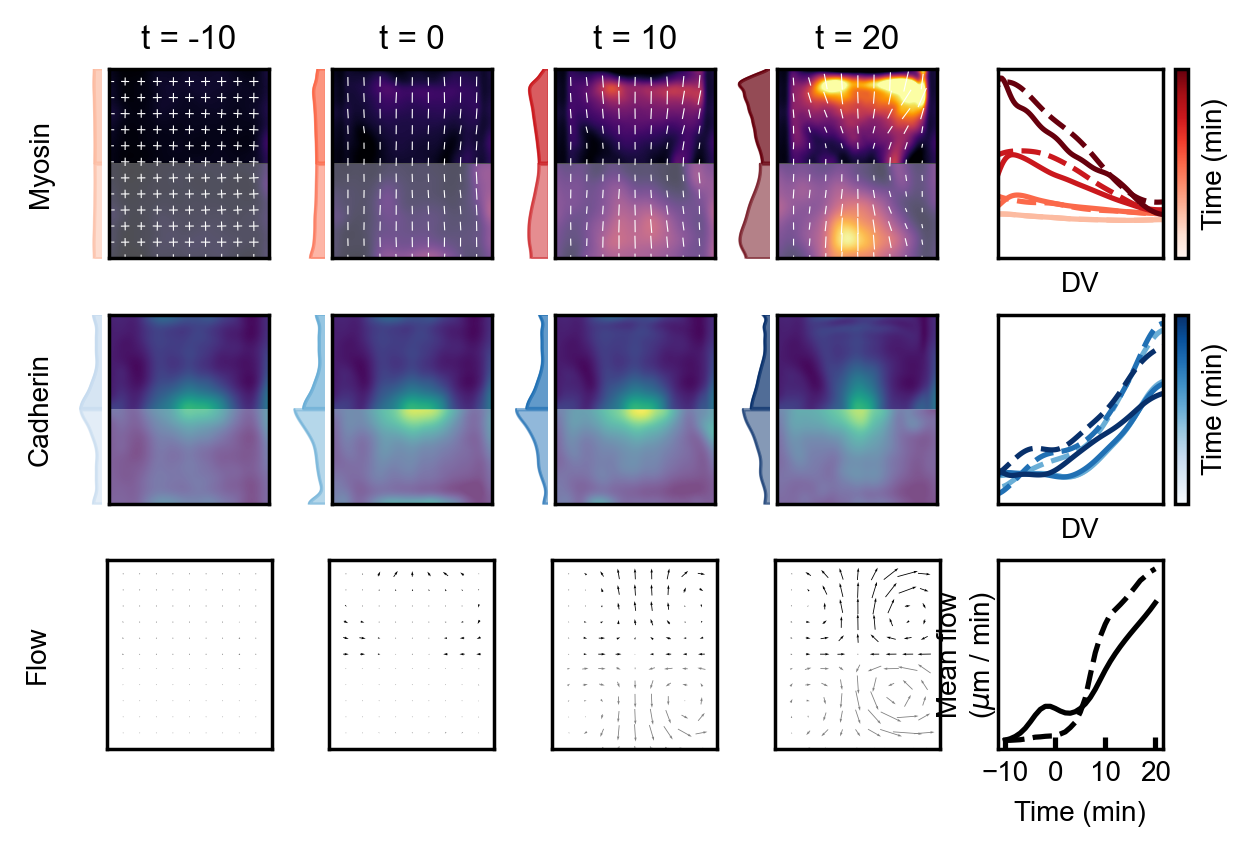

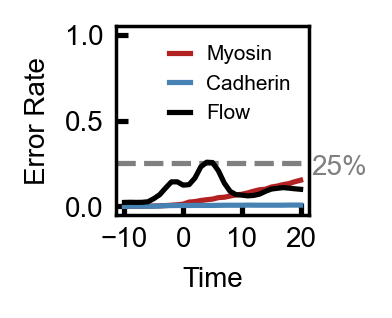

In [3]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/November2023/ForecastingVAE_sqh_beta=0.0001_split=embryo') #Works well with sigma = 5
print(info['hparams'])

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)

fig1, fig2 = comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)

In [3]:
import torch
print(torch.__file__)

/project/vitelli/ml_venv/lib/python3.7/site-packages/torch/__init__.py


In [8]:
info['loss'], info['res_std']

(0.060695871444685114, 0.016837573732629632)

In [4]:
info.keys()

dict_keys(['state_dict', 'hparams', 'epoch', 'loss', 'res', 'res_sem', 'res_std', 'val_df'])

In [6]:
np.save('Figures/Forecasting/m0', m0)
np.save('Figures/Forecasting/v0', v0)
np.save('Figures/Forecasting/c0', s0)
np.save('Figures/Forecasting/m', m)
np.save('Figures/Forecasting/v', v)
np.save('Figures/Forecasting/c', s)
np.save('Figures/Forecasting/time', t0)


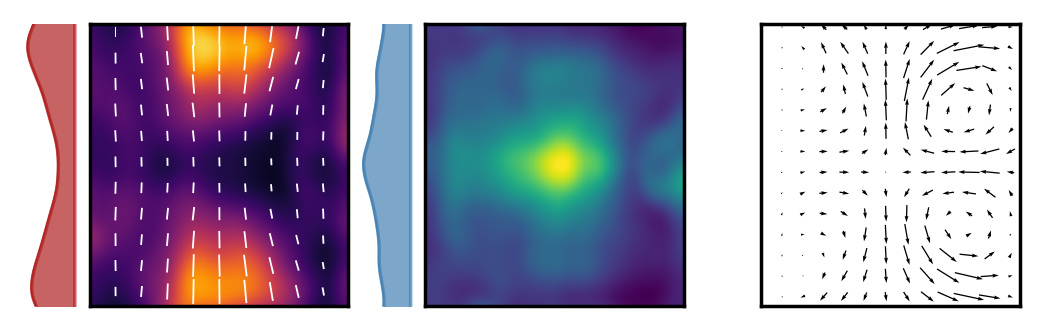

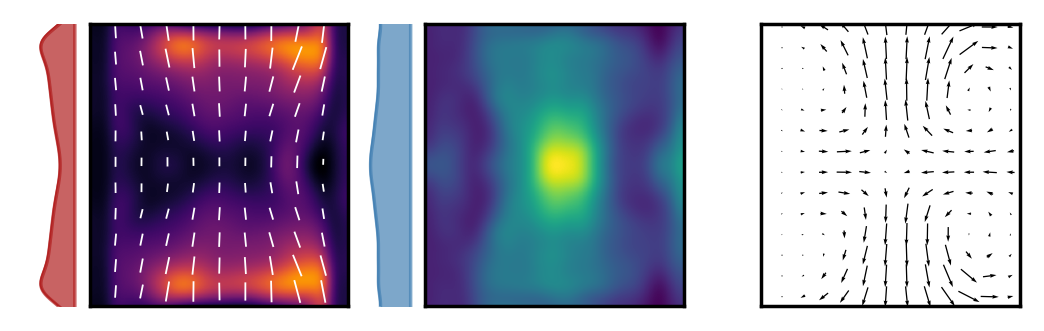

In [7]:
from utils.plot_utils import *
from utils.decomposition.decomposition_model import LeftRightSymmetrize

def plot_cut(ax, z, color):
    znorm = np.linalg.norm(z.reshape([-1, 236, 200]), axis=0)
    cut = np.mean(znorm[:, 80:120], axis=-1)
    
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    y = np.linspace(dv_min, dv_max, cut.shape[0])
    ax_Y.plot(cut, y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 0, cut, color=color, alpha=0.7)
    ax_Y.invert_xaxis()
    ax_Y.axis('off')
    ax.set_ylim([dv_min+of, dv_max-of])    
    return ax_Y


mmin = np.min(np.linalg.norm(m0[..., :-20], axis=(1, 2)))
mmax = np.max(np.linalg.norm(m0[..., :-20], axis=(1, 2)))

of = 20
tt = 25

fig, ax = plt.subplots(1, 3, dpi=250, figsize=(6*0.8, 2))
plot_tensor2D(ax[0], m0[tt], vmin=mmin, vmax=mmax)
ax_m0 = plot_cut(ax[0], m0[tt], 'firebrick')
color_2D(ax[1], s0[tt])
ax_c0 = plot_cut(ax[1], s0[tt], 'steelblue')
plot_vector2D(ax[2], v0[tt], skip=16)
ax[2].set_ylim([dv_min+of, dv_max-of])    
fig.subplots_adjust(wspace=0.3)

fig, ax = plt.subplots(1, 3, dpi=250, figsize=(6*0.8, 2))
mtt = LeftRightSymmetrize().fit_transform(m[tt].reshape([1, 4, 236, 200]))[0]
plot_tensor2D(ax[0], mtt, vmin=mmin, vmax=mmax)
ax_m = plot_cut(ax[0], mtt, 'firebrick')
ax_m.set_xlim(ax_m0.get_xlim())
stt = LeftRightSymmetrize().fit_transform(s[tt:tt+1])[0]
color_2D(ax[1], stt)
ax_c = plot_cut(ax[1], stt, 'steelblue')
ax_c.set_xlim(ax_c0.get_xlim())
plot_vector2D(ax[2], LeftRightSymmetrize().fit_transform(v[tt:tt+1])[0], skip=16)
ax[2].set_ylim([dv_min+of, dv_max-of])    
fig.subplots_adjust(wspace=0.3)
